# Decompostion
- There are various regimes for signal decomposition.
- Examples:
    - Fast Fourier Transform (FFT)
    - Wavelets
    - Linear components
- Motviation:
    - Trend discovery
    - Low-pass filter
    - Exploratory data analysis

## Fast Fourier Transform
### FFT history and application
- An important workhorse in signal processing.
- Can be traced back to Carl Friedrich Gauss on Discrete Fourier Transforms from 1805.
- Major milestone in 1965 by James Cooley and John Tukey regarding speed of computations and applications in detecting Soviet nuclear bomb tests.
- Used in anything from mathematical speed-ups, via video and music compression, modern signal processing in Wi-Fi, 5G, etc. to finance.

### FFT function
- Wikipedia: A Fourier Transform is a transform that converts a function into a form that describes the frequencies present in the original function.
- scipy.fft: Fourier analysis is a method for expressing a function as a sum of peridoic components, and for recovering the signal from those components.
  
$$X_k = \sum_{n=0}^{N-1} x_n e^{i2 \pi kn/N} ~~~~ k = 0, ..., N-1$$
- Here, _k_ is the index of a signal, __X__, and _N_ is its length. $x_n$ is a coefficient to be fitted.

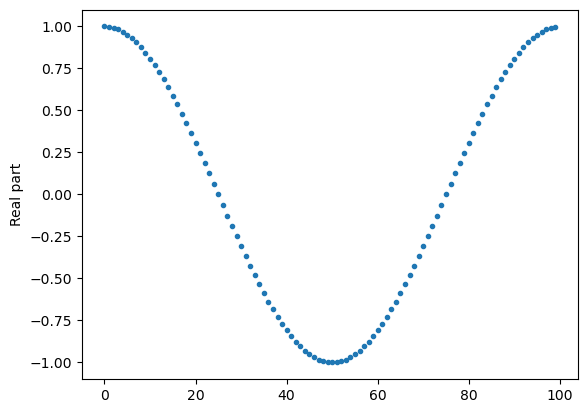

In [1]:
import numpy as np
import matplotlib.pyplot as plt
N = 100
n = 1
x = [np.exp(1j * 2 * np.pi * k * n / N) for k in range(N)]
plt.plot(range(N), np.real(x), '.')
plt.ylabel('Real part')
plt.show()

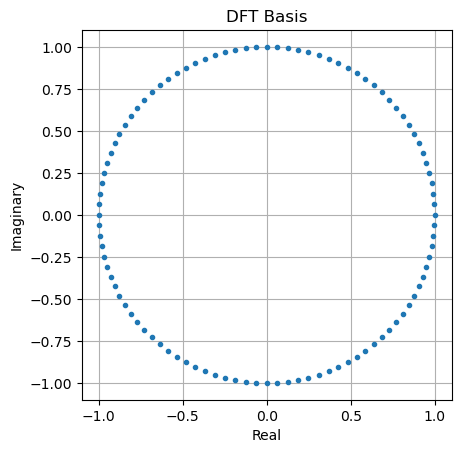

In [2]:
# The full complex exponential basis
plt.plot(np.real(x), np.imag(x), '.')
plt.axis('square')
plt.grid()
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.title('DFT Basis')
plt.show()

### Direct Cosine Transform (DCT)
- FFT with real valued data.
- For real numbered signals, the definition above can be exchanged with a version based on the cosine or sine functions.
- There are theoretically 8+8 "types", 4+4 of which are implemented in SciPy, and various choices for normalisation.
- Type I DCT (Direct Cosine Transform) as implemented in SciPy:
$$y_k = x_0 + (-1)^k x_{N-1} + 2 \sum_{n=1}^{N-2} x_n cos (\frac{\pi k n}{N-1}))$$
 - Quicker than FFT and guarantees real valued frequency domain.
 - Positive signal follow the base cosine waves, while negative signals indicate a horizontal shift of the cosine wave.

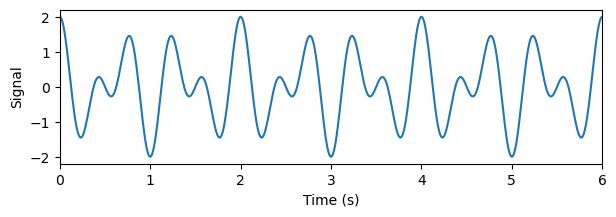

Sampling of the time axis: 100.0 Hz


In [3]:
# Sum of two cosines with different frequencies.
import numpy as np
from scipy.fft import dct, idct

N = 601
s = 6
time   = np.linspace(0,s,N)
signal = np.cos(3 * np.pi * time) + np.cos(5 * np.pi * time)

# Plot the signal
import matplotlib.pyplot as plt
plt.figure(figsize=(7,2))
plt.plot(time, signal)
plt.xlabel('Time (s)')
plt.ylabel('Signal')
plt.xlim(0,s)
plt.show()

# Print the resolution of the time axis in Hz
dt = time[1] - time[0]
print('Sampling of the time axis:', 1/dt, 'Hz')

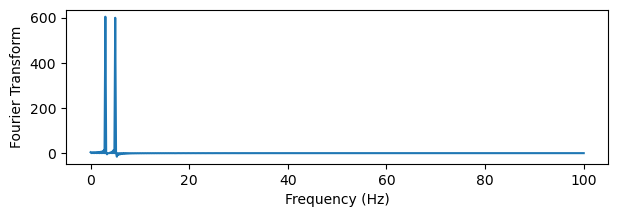

In [4]:
# Discrete Cosine transform
fourier_signal = dct(np.concatenate([np.zeros(0),signal])) # Pad with zeros to shift signal
dt = time[1] - time[0]
W = np.linspace(0, 1/dt, N)
#                   ^-- Frequency axis in Hz

# Plot the Fourier transform
plt.figure(figsize=(7,2))
plt.plot(W, fourier_signal)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Fourier Transform')
#plt.xlim(0,10)
plt.show()

### FFT filtering
- We can apply the FFT to analyse the frequencies present or to filter the signal.
    - Filtering here means that some frequencies are removed from the signal.
- Typical filters are:
    - Low-pass filter: Remove high frequencies, e.g., noise or short-term changes, focusing on trends or slowly changing signals.
    - High-pass filter: Remove low frequencies, e.g., trends or baselines, focusing on rapid changes or anomalies.

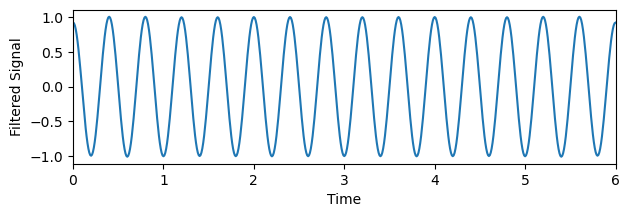

In [5]:
# Remove frequencies below 4, i.e., a high-pass filter
filtered_fourier_signal = fourier_signal.copy()
filtered_fourier_signal[(W<4)] = 0 # <- Come playe with me!
cut_signal = idct(filtered_fourier_signal)

# Plot the filtered signal
plt.figure(figsize=(7,2))
plt.plot(time, cut_signal)
plt.xlabel('Time')
plt.ylabel('Filtered Signal')
plt.xlim(0,6)
plt.show()

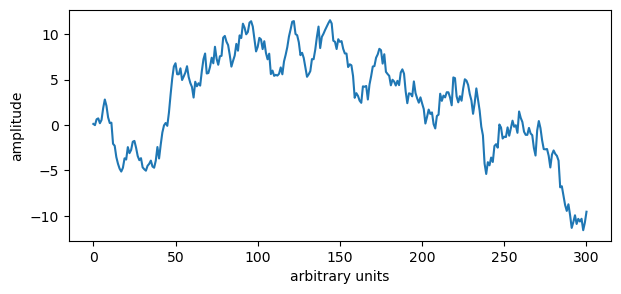

In [6]:
# A curve we have seen before
N = 301
rng = np.random.default_rng(0)
y = rng.standard_normal(N).cumsum()

# Plot the curve
plt.figure(figsize=(7,3))
plt.plot(y)
plt.xlabel('arbitrary units')
plt.ylabel('amplitude')
plt.show()

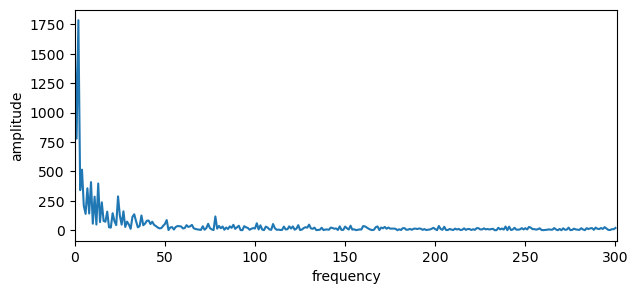

In [7]:
# Plot the Fourier transform
plt.figure(figsize=(7,3))
plt.plot(np.abs(dct(y))) # Not caring about the phase
plt.xlabel('frequency')  # Think 1/width of time series
plt.ylabel('amplitude')
plt.xlim(0,N)
plt.show()

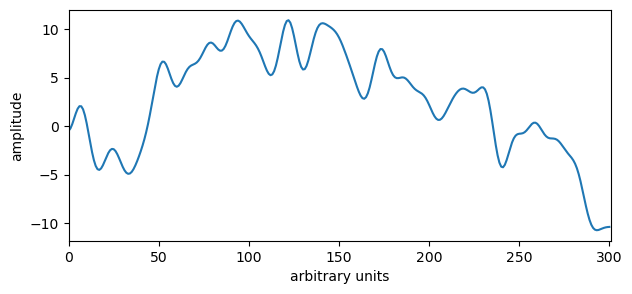

In [8]:
# Remove frequencies above 50, i.e., a low-pass filter.
W = np.arange(0, N) # Frequency axis
filtered_fourier_signal = dct(y).copy()
filtered_fourier_signal[(W>50)] = 0
cut_signal = idct(filtered_fourier_signal)

# Plot the filtered signal
plt.figure(figsize=(7,3))
plt.plot(cut_signal)
plt.xlabel('arbitrary units')
plt.ylabel('amplitude')
plt.xlim(0,N)
plt.show()

## Linear decomposition
- Various forms of linear models can be used for decomposition, each having different focus or optimality criteria, e.g.:
    - Season-Trend decomposition using LOESS in the [statmodels package](https://www.statsmodels.org/stable/examples/notebooks/generated/stl_decomposition.html)
    - Multivariate explorative data analysis with [Principal Coponent Analysis](https://hoggorm.readthedocs.io/en/latest/pca.html).

### Seasonal-Trend decomposition using LOESS (STL)
- STL takes a (time) series as input together with an estimate of period length.
- Output are:
    - A trend along the series.
    - A seasonal signal which may evolve along the series.
    - A residual.
- Additional parameters:
    - Length of smoothers for trend and season (high number = less change).
    - Use weighting of samples for robustness (allow more individual deviation from trend/season).

In [9]:
# Monthly sunspots from https://github.com/jbrownlee/Datasets

# Load the data
import pandas as pd
sunspots = pd.read_csv("../../data/monthly-sunspots.csv", header=0)
print(sunspots.shape)
sunspots.head()

(2820, 2)


,Month,Sunspots
0,1749-01,58.0
1,1749-02,62.6
2,1749-03,70.0
3,1749-04,55.7
4,1749-05,85.0


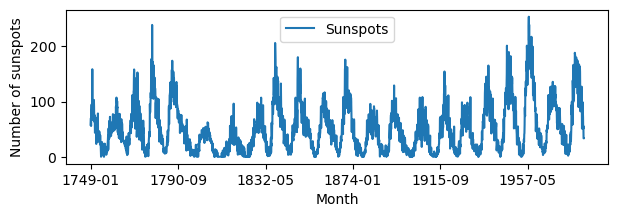

In [10]:
# Plot the data
sunspots.plot.line(x='Month', y='Sunspots', figsize=(7,2))
plt.xlabel('Month')
plt.ylabel('Number of sunspots')
plt.show()

In [11]:
# Approximate periodicity: Lenght of series divided by number of periods.
# For sunspots we know that there is a periodicity of approximately 11 years.
np.round(2820/21)

134.0

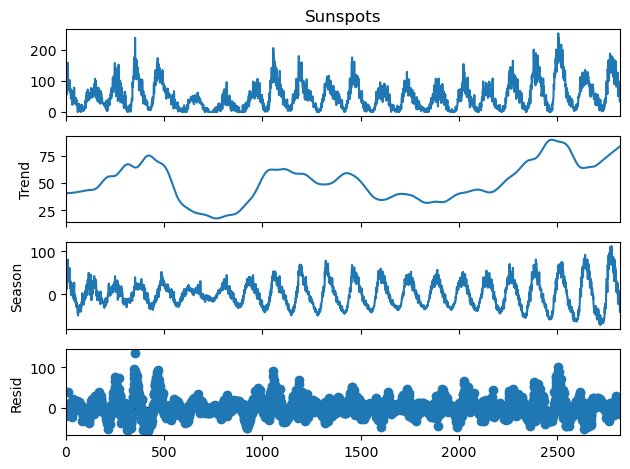

In [12]:
from statsmodels.tsa.seasonal import STL
stl = STL(sunspots["Sunspots"], period=134)#, robust=True, seasonal=1001, trend=1001)
res = stl.fit() # Contains the components and a plot function
fig = res.plot()

In [13]:
# Daily Female Births in California from https://github.com/jbrownlee/Datasets

# Load the data
births = pd.read_csv("../../data/daily-total-female-births.csv", header=0)
births.head()

,Date,Births
0,1959-01-01,35
1,1959-01-02,32
2,1959-01-03,30
3,1959-01-04,31
4,1959-01-05,44


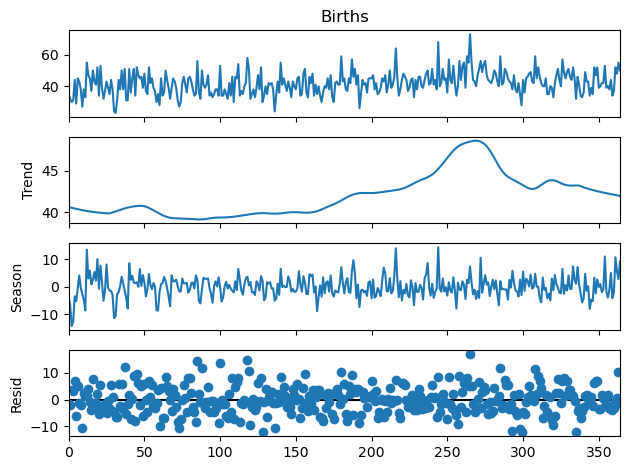

In [14]:
stl = STL(births["Births"], period=28)
res = stl.fit()
fig = res.plot()

### Excercise
- Force the period to change less.
- Extract the trend and plot it as a function of time.
- Indicate the date of maximum number of conceptions (~9 months before birth), assuming the year is cyclic.

### Multiple seasonalities
- If a there is more than one phenomenon with a cyclic behaviour, multiple seasonalities can be found through Multiple Seasonal-Trend decomposition using LOESS (MSTL).
- The more complex model one applies, the higher the chances of overfitting!
- [Example at statmodels.org](https://www.statmodels.org/dev/examples/notebooks/generated/mstl_decomposition.html)

### Principal Component Analysis (PCA)
- For (time) series with multiple variables, PCA can give a first indication of structure and connection between variables.
- Scores show paths of time points, loadings show how variables relate.
- One PCA formulation for input data $\mathbf{X}$ with series as columns:
$$\mathbf{U} \mathbf{S} \mathbf{V}' = svd(\mathbf{X}-\bar{\mathbf{X}})$$
$$\mathbf{T} = \mathbf{U} \mathbf{S} \text{ - scores}$$
$$\mathbf{P} = \mathbf{V}' \text{ - loadings}$$


### Beijing pollution data
This dataset is originally from [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/381/beijing+pm2+5+data) and shows hourly measurements of weather at the US embassy in Bejing. Its columns are:
1. No: row number
2. year: year of data in this row
3. month: month of data in this row
4. day: day of data in this row
5. hour: hour of data in this row
6. pm2.5: PM2.5 concentration ($\mu g/m^3$)
7. DEWP: Dew Point ($^{\circ}F$)
8. TEMP: Temperature ($^{\circ}F$)
9. PRES: Pressure (_hPa_)
10. cbwd: Combined wind direction
11. Iws: Cumulated wind speed
12. Is: Cumulated hours of snow
13. Ir: Cumulated hours of rain

In [15]:
# Beijing pollution data from https://github.com/jbrownlee/Datasets

# Load the data
pollution = pd.read_csv("../../data/pollution.csv", header=0, index_col=0)
print(pollution.shape)
pollution.head()

(43824, 12)


,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
No,,,,,,,,,,,,
1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [16]:
# Recode the cbwd column using one-hot encoding and add to the data frame
pollution = pd.concat([pollution, pd.get_dummies(pollution["cbwd"])], axis=1)
pollution = pollution.drop(columns=["cbwd"])
pollution.head()

,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir,NE,NW,SE,cv
No,,,,,,,,,,,,,,,
1,2010,1,1,0,NaN,-21,-11.0,1021.0,1.79,0,0,0,1,0,0
2,2010,1,1,1,NaN,-21,-12.0,1020.0,4.92,0,0,0,1,0,0
3,2010,1,1,2,NaN,-21,-11.0,1019.0,6.71,0,0,0,1,0,0
4,2010,1,1,3,NaN,-21,-14.0,1019.0,9.84,0,0,0,1,0,0
5,2010,1,1,4,NaN,-20,-12.0,1018.0,12.97,0,0,0,1,0,0


In [17]:
# Replace NaN with 0 in the pm2.5 column
pollution["pm2.5"] = pollution["pm2.5"].fillna(0)
pollution.head()

,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir,NE,NW,SE,cv
No,,,,,,,,,,,,,,,
1,2010,1,1,0,0.0,-21,-11.0,1021.0,1.79,0,0,0,1,0,0
2,2010,1,1,1,0.0,-21,-12.0,1020.0,4.92,0,0,0,1,0,0
3,2010,1,1,2,0.0,-21,-11.0,1019.0,6.71,0,0,0,1,0,0
4,2010,1,1,3,0.0,-21,-14.0,1019.0,9.84,0,0,0,1,0,0
5,2010,1,1,4,0.0,-20,-12.0,1018.0,12.97,0,0,0,1,0,0


In [18]:
# PCA of pollution data
from hoggorm.pca import nipalsPCA as PCA
pca = PCA(pollution.iloc[:,4:].values, numComp=4, Xstand=True)

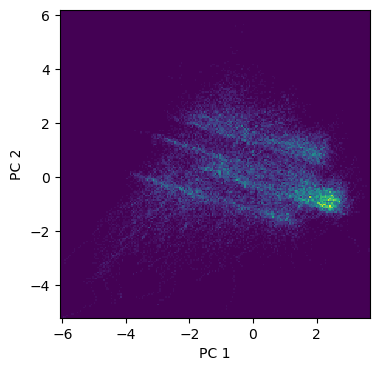

In [19]:
# Make a 2D histogram of the X_scores (too many points for a scatter plot)
plt.figure(figsize=(4,4))
plt.hist2d(pca.X_scores()[:,0], pca.X_scores()[:,1], bins=200)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.show()

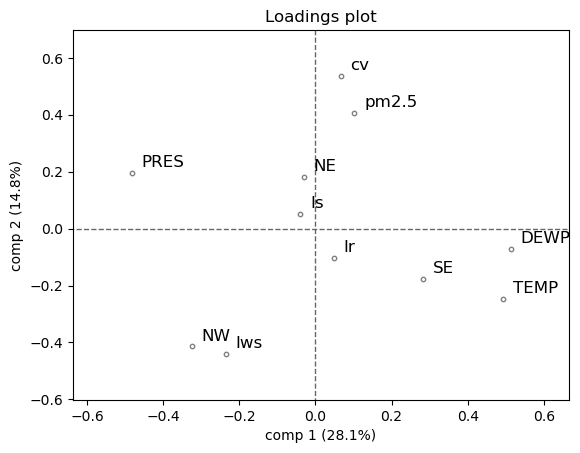

In [20]:
# Loading plot
from hoggormplot import loadings
loadings(pca, comp=[1,2], XvarNames=pollution.columns[4:].tolist())
plt.show()

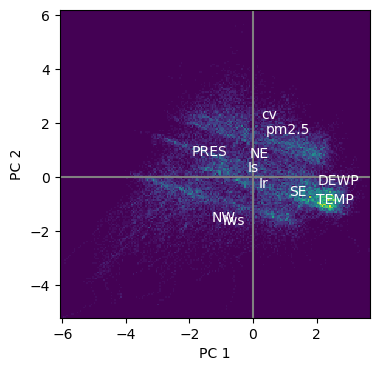

In [21]:
# Make a 2D histogram of the X_scores (too many points for a scatter plot)
plt.figure(figsize=(4,4))
plt.hist2d(pca.X_scores()[:,0], pca.X_scores()[:,1], bins=200)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
labs = pollution.columns[4:].tolist()
# Add an axis cross in gray using axhline and axvline
plt.axhline(0, color="gray")
plt.axvline(0, color="gray")
# Add the loadings as text (labs) in white on top of the histogram, scale to the same range as the histogram
for i in range(len(labs)):
    plt.text(pca.X_loadings()[i,0]*4, pca.X_loadings()[i,1]*4, labs[i], color="white")
plt.show()

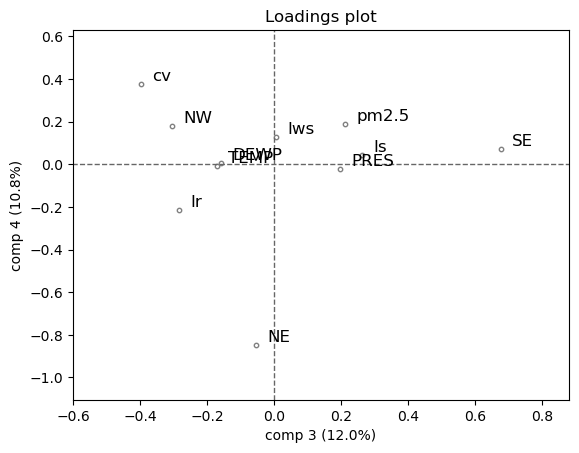

In [22]:
# Plot the 3rd and 4th components
loadings(pca, comp=[3,4], XvarNames=pollution.columns[4:].tolist())
plt.show()

## Resources
- [Wikipedia: Fast Fourier Transform](https://en.wikipedia.org/wiki/Fast_Fourier_transform)
- [Wikipedia: Discrete Cosine Transform](https://en.wikipedia.org/wiki/Discrete_cosine_transform)
- [SciPy: Fourier Transforms](https://docs.scipy.org/doc/scipy/tutorial/fft.html)
- [Seasonal-Trend decomposition using LOESS](https://www.statsmodels.org/stable/examples/notebooks/generated/stl_decomposition.html)
- [YouTube: Veritasium - the history of FFT](https://youtu.be/nmgFG7PUHfo?si=fx2C0vuByBqorCAS) (26m:33s)